In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import calendar
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel

pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

os.chdir("E:/Trinity/Dissertation/Sem 3/models/data/")

Read the new DataFrame

In [38]:
os.chdir("E:/Trinity/Dissertation/Sem 3/models/")
df = pd.read_csv("boost_classifier_data.csv")  

### MODEL

In [39]:
# day of week ois important
# not keep isHoliday ---- 141.49
# keep isHoliday ---- 141.08
# Hyper parameter tuning ---- 141.06
df_x = df.drop(["No_of_Cars", "Date", "EndTime", "Year", "Tolls", "Congestion?"],axis=1)
df_y = df["Congestion?"]

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.80, random_state=100)

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [42]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [43]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])
    return model

In [44]:
model = build_model()

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                1280      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________


In [28]:
#model.predict(x_test)

In [55]:
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=10)
history = model.fit(  x_train.values, y_train.values, #batch_size=32,
                      epochs=EPOCHS, validation_split = 0.10, verbose=1,
                      callbacks=[early_stop],
                      validation_data=(x_test, y_test))

Train on 109644 samples, validate on 27411 samples
Epoch 1/100
109644/109644 [==============================] - 21s 193us/sample - loss: 0.0296 - acc: 0.9933 - val_loss: 0.0284 - val_acc: 0.9924
Epoch 2/100
109644/109644 [==============================] - 21s 190us/sample - loss: 0.0293 - acc: 0.9932 - val_loss: 0.0268 - val_acc: 0.9934
Epoch 3/100
109644/109644 [==============================] - 20s 180us/sample - loss: 0.0288 - acc: 0.9934 - val_loss: 0.0294 - val_acc: 0.9934
Epoch 4/100
109644/109644 [==============================] - 21s 190us/sample - loss: 0.0286 - acc: 0.9935 - val_loss: 0.0292 - val_acc: 0.9927
Epoch 5/100
109644/109644 [==============================] - 20s 183us/sample - loss: 0.0281 - acc: 0.9937 - val_loss: 0.0617 - val_acc: 0.9866
Epoch 6/100
109644/109644 [==============================] - 20s 184us/sample - loss: 0.0275 - acc: 0.9938 - val_loss: 0.0259 - val_acc: 0.9937
Epoch 7/100
109644/109644 [==============================] - 20s 185us/sample - loss:

In [46]:
model.evaluate(x_test, y_test)[1]

27411/27411 [==============================] - 3s 102us/sample - loss: 0.0293 - acc: 0.9926


0.9926307

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,val_loss,val_acc,epoch
15,0.033383,0.991919,0.029342,0.992996,15
16,0.033578,0.991436,0.030403,0.992156,16
17,0.031925,0.992284,0.030343,0.993360,17
18,0.031166,0.992448,0.032629,0.991317,18
19,0.031292,0.992403,0.029339,0.992631,19


In [49]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [52]:
hist.acc.max()

0.9924482703208923

Text(0, 0.5, 'Accuracy')

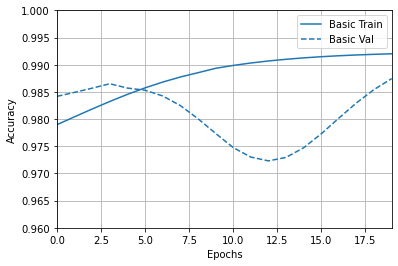

In [54]:
plotter.plot({'Basic': history}, metric = "acc")
plt.ylim([0.96, 1])
plt.ylabel('Accuracy')

In [ ]:
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

In [ ]:
ypred = model.predict(x_test)

In [ ]:
data = pd.DataFrame(ypred, y_test).reset_index()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data["No_of_Cars"].head(100), label="Actual")
plt.plot(data[0].head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [ ]:
test = pd.DataFrame(y_test)
pred = pd.DataFrame(ypred)
final = pd.concat([test, pred], axis=1)
test.to_csv("test.csv")
pred.to_csv("pred.csv")
# manually merge the CSVs

In [ ]:
data = pd.read_csv("test.csv")
data = data.set_index('Index')


In [ ]:
merged = pd.merge(left=df, left_index=True,
                  right=data, right_index=True,
                  how='inner')

In [ ]:
merged.head()

In [ ]:
final = merged[["Date","Tolls","StartTime","DayOfWeek","isHoliday?","No_of_Cars_y","Predicted"]]

final["Inaccuracy"] = abs(final["No_of_Cars_y"] - final["Predicted"])
final["Precision"] = final["Inaccuracy"]/final["No_of_Cars_y"]

final = final.sort_values("Precision", ascending=False)

#final[(final["Precision"]>1) & (final["No_of_Cars_y"]>10)]

In [ ]:
final.head()

In [ ]:
final.to_csv("RF_Predictions.csv", index=False)
#del(final)
del(test)
del(merged)
del(pred)
del(data)